# Практикум №2 
# Абраменко Микити Олександровича, студента групи КА-01
# 1 варіант
## Полiномiальна регресiя, алгоритм градiєнтного спуску за мiнi-батчами, MSE з регуляризацiєю за нормою L2.

Регуляризація за нормою l2 - Ridge

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

NUM_EPOCHS = 100
DEGREE_1 = 5
DEGREE_2 = 3

rng = np.random.default_rng(17)
tf.random.set_seed(17)

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Створимо кастомний колбек який буде виводити значення функції втрат, та інші метрики кожні 10 епох

In [2]:
class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % 10 == 0:
            print(f'Epoch {epoch}: Loss = {logs["loss"]:.4f}, R_square = {logs["r_square"]:.4f}, MSE = {logs["mean_squared_error"]:.4f}, \
                  \n Val Loss = {logs["val_loss"]}, Val R Square = {logs["val_r_square"]}, Val MSE = {logs["val_mean_squared_error"]} \n')

# Перший набір данних 

In [190]:
X_data = np.linspace(-1, 1, 101)

num_coef = 4
coef = [-100, 2, 1, 100]
y_data = 0
for i in range (num_coef):
    y_data += coef[i] * np.power(X_data, i)
    y_data += rng.standard_normal(*X_data.shape)*20.5 # код був трохи змінений задля використання більш актуальних методів генерування псевдорандомних чисел за допомогою бібліотеки Numpy

Text(0, 0.5, 'y')

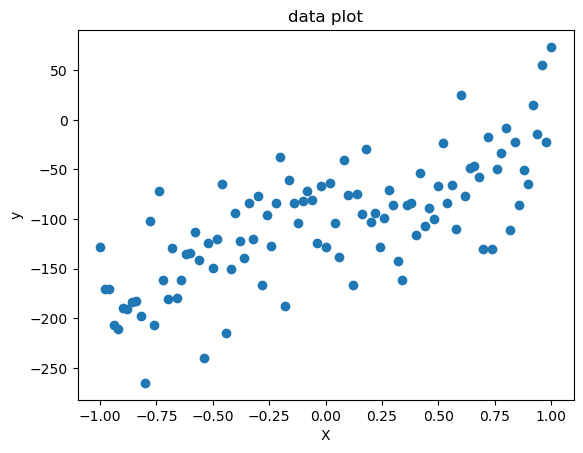

In [191]:
plt.scatter(x=X_data, y=y_data)
plt.title('data plot')
plt.xlabel('X')
plt.ylabel('y')

Нормалізуємо дані, та створимо датасет з поліномами для поліноміальної регресії, як степінь оберемо 5

Ми створимо 3 датасети, навчальний, валідаційний, для підбору гіперпараметрів, та тестовий, для остаточного оцінювання моделі, моделі які будемо перевіряти на тестовому датасеті ми будемо навчати на комбінації навчального датасету та валідаційного

In [192]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=17)

poly = PolynomialFeatures(degree=DEGREE_1)

X_train = poly.fit_transform(X_train.reshape(-1, 1))
X_train_val = poly.transform(X_train_val.reshape(-1, 1))
X_test = poly.transform(X_test.reshape(-1, 1))
X_val = poly.transform(X_val.reshape(-1, 1))
X = poly.transform(X_data.reshape(-1, 1))

stdscaler = StandardScaler()

y_train = stdscaler.fit_transform(y_train.reshape(-1, 1))
y_train_val = stdscaler.transform(y_train_val.reshape(-1, 1))
y_test = stdscaler.transform(y_test.reshape(-1, 1))
y_val = stdscaler.transform(y_val.reshape(-1, 1))
y = stdscaler.transform(y_data.reshape(-1, 1))

Подивимося на описову статистику для нашої цільової змінної

In [193]:
pd.Series(y.flatten()).describe()

count    101.000000
mean      -0.010781
std        1.044302
min       -2.755521
25%       -0.620379
50%        0.053019
75%        0.623442
max        2.999432
dtype: float64

In [194]:
X_tf = tf.constant(X, dtype=tf.float32)
y_tf = tf.constant(y, dtype=tf.float32)

X_tf_train = tf.constant(X_train, dtype=tf.float32)
X_tf_train_val = tf.constant(X_train_val, dtype=tf.float32)
X_tf_test = tf.constant(X_test, dtype=tf.float32)
X_tf_val = tf.constant(X_val, dtype=tf.float32)

y_tf_train = tf.constant(y_train, dtype=tf.float32)
y_tf_train_val = tf.constant(y_train_val, dtype=tf.float32)
y_tf_test = tf.constant(y_test, dtype=tf.float32)
y_tf_val = tf.constant(y_val, dtype=tf.float32)

Для підбору гіперпараметрів я буду використовувати бібліотеку Optuna, тому ініціалізуємо потрібні для неї функції та об'єкти

In [195]:
def objective(trial):
    
    c_lambda_1 = trial.suggest_float("lambda_1", 1e-5, 1, log=True)
    c_lambda_2 = trial.suggest_float("lambda_2", 1e-5, 1, log=True)
    lrng_rate = trial.suggest_float("lrng_rate", 1e-5, 1, log=True)
    batch_size = trial.suggest_int("batch_size", 2, 32, 1)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(DEGREE_1 + 1,), kernel_regularizer=tf.keras.regularizers.l2(c_lambda_1)),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(c_lambda_2)),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lrng_rate),
            loss='mean_squared_error',
            metrics = [tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

    model.fit(X_tf_train, y_tf_train,
                    epochs=NUM_EPOCHS,
                    verbose=0, batch_size=batch_size,
                    validation_data=(X_tf_val, y_tf_val))

    score = model.evaluate(X_tf_val, y_tf_val, verbose=0)
    return score[0]

In [196]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=15, timeout=600, n_jobs=-1)

[I 2023-05-23 14:59:48,553] A new study created in memory with name: no-name-3261163d-227a-4f46-8cd0-93772efd221d
[I 2023-05-23 15:00:01,613] Trial 0 finished with value: 0.9181675910949707 and parameters: {'lambda_1': 0.00017424226630180964, 'lambda_2': 1.3550075986081241e-05, 'lrng_rate': 0.005671731043450945, 'batch_size': 22}. Best is trial 0 with value: 0.9181675910949707.
[I 2023-05-23 15:00:04,131] Trial 3 finished with value: 1.7151963710784912 and parameters: {'lambda_1': 4.270492223808017e-05, 'lambda_2': 0.01638791298394639, 'lrng_rate': 0.39996029709608544, 'batch_size': 14}. Best is trial 0 with value: 0.9181675910949707.
[I 2023-05-23 15:00:05,314] Trial 5 finished with value: 1.8400349617004395 and parameters: {'lambda_1': 0.02928521218772426, 'lambda_2': 0.0007122447676007578, 'lrng_rate': 2.2412155933076023e-05, 'batch_size': 10}. Best is trial 0 with value: 0.9181675910949707.
[I 2023-05-23 15:00:07,921] Trial 4 finished with value: 3.980646848678589 and parameters: {

In [197]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 15
Best trial:
  Value: 0.6525214314460754
  Params: 
    lambda_1: 3.7190222756230116e-05
    lambda_2: 9.891722502221714e-05
    lrng_rate: 0.22904557532654365
    batch_size: 22


Тепер ми створимо нову модель з найкращими параметрами і навчимо на датасетах для навчання та валідації і протестуємо на тестовому

In [198]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(DEGREE_1 + 1,), kernel_regularizer=tf.keras.regularizers.l2(1.178)),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0009)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0134),
              loss='mean_squared_error',
              metrics=[tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_tf_train_val, y_tf_train_val,
                    epochs=NUM_EPOCHS,
                    callbacks=[PrintLossCallback(),
                               tf.keras.callbacks.ModelCheckpoint(filepath="model_numpy_isprr2_1",
                                                                  save_best_only=True, verbose=0,
                                                                  save_weights_only=True)],
                    verbose=0, batch_size=8,
                    validation_data=(X_tf_test, y_tf_test))

y_pred_test = model.predict(X_tf_test)
y_pred_full = model.predict(X_tf)

Epoch 0: Loss = 7.0225, R_square = 0.0104, MSE = 1.1058,                   
 Val Loss = 5.017640113830566, Val R Square = 0.009613037109375, Val MSE = 0.9274373054504395 

Epoch 10: Loss = 0.9533, R_square = 0.2352, MSE = 0.8546,                   
 Val Loss = 0.789974570274353, Val R Square = 0.2688570022583008, Val MSE = 0.6846711039543152 

Epoch 20: Loss = 0.7546, R_square = 0.4557, MSE = 0.6082,                   
 Val Loss = 0.6295586824417114, Val R Square = 0.4730696678161621, Val MSE = 0.4934382736682892 

Epoch 30: Loss = 0.6850, R_square = 0.4908, MSE = 0.5690,                   
 Val Loss = 0.5796058177947998, Val R Square = 0.5142059326171875, Val MSE = 0.45491668581962585 

Epoch 40: Loss = 0.6807, R_square = 0.4904, MSE = 0.5694,                   
 Val Loss = 0.5512518286705017, Val R Square = 0.5228689908981323, Val MSE = 0.4468042254447937 

Epoch 50: Loss = 0.6516, R_square = 0.4931, MSE = 0.5664,                   
 Val Loss = 0.6693744659423828, Val R Square = 0.38

Як ми можемо побачити ми отримали досить низьке значення функції втрат, і враховуючи те, що це звичайне MSE, а не RMSE, то можна сказати, що і зовсім прекрасне значення, щодо значення R^2, то я вважаю, що було б дещо несподівано отримати значення цієї метрики більшим, адже наші дані досить досить сильно розсіяні навколо середнього

Також ми можемо помітити, що наше значення функції втрат, та метрика MSE мають різне значення, хоч і наша функція втрат і є - MSE, це пов'язано з різницею використання метрики та функції втрат, у метрики є крок усреднення для усіх мінібатчей серед датасету, а для функції втрат кроку усреднення немає, тому значення метрики більш важливе як показник міри адекватності моделі

Text(0, 0.5, 'y')

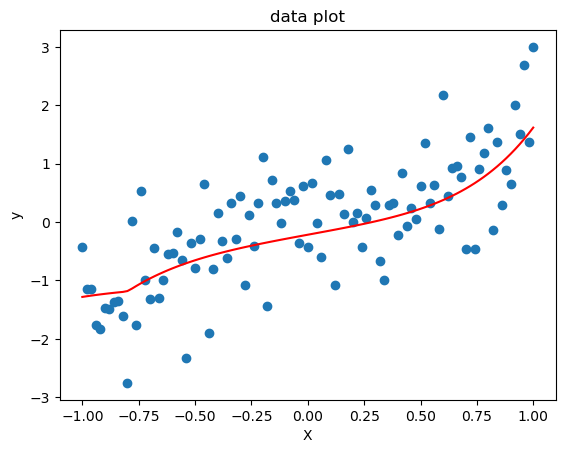

In [199]:
plt.scatter(x=X[:, 1], y=y)
plt.plot(X[:, 1], y_pred_full, c='red')
plt.title('data plot')
plt.xlabel('X')
plt.ylabel('y')

Як ми можемо побачити наша модель гарно пристосувалася до данних

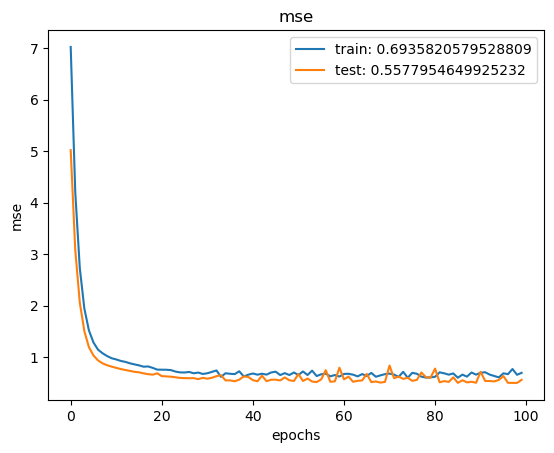

In [200]:
plt.plot(history.history['loss'], label=f"train: {history.history['loss'][-1]}")
plt.plot(history.history['val_loss'], label=f"test: {history.history['val_loss'][-1]}")
plt.xlabel("epochs")
plt.ylabel("mse")
plt.title('mse')
plt.legend()
plt.show()

Як ми можемо побачити, наші значення функції втрат рівномірно спадали як для навчального датасету, так і для тестового

Ми створили дуже гарну модель яка змогла створити криву яка пристосувалася до нашого датасету, та має низькі значення похибок, та наскільки, це можливо для данних, високе значення R^2

# Другий набір данних

In [20]:
data_2 =  pd.read_csv('NFLX.csv', index_col='Date', parse_dates=True)

Подивимось на датасет:

In [21]:
data_2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000
...,...,...,...,...,...,...
2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995,10476100
2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993,5589800
2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002,4766600


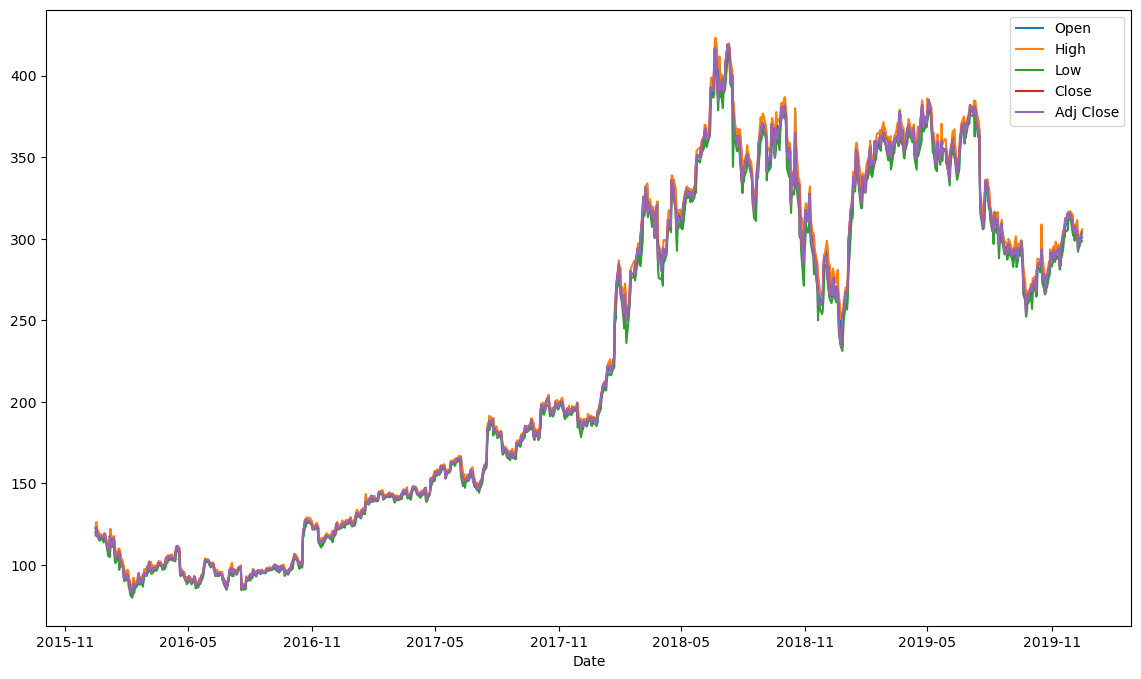

In [22]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(data_2.Open, label='Open')
ax.plot(data_2.High, label='High')
ax.plot(data_2.Low, label='Low')
ax.plot(data_2.Close, label='Close')
ax.plot(data_2['Adj Close'], label='Adj Close')

myFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.set_xlabel('Date')


plt.legend()
plt.show()

<AxesSubplot: xlabel='Date', ylabel='Volume'>

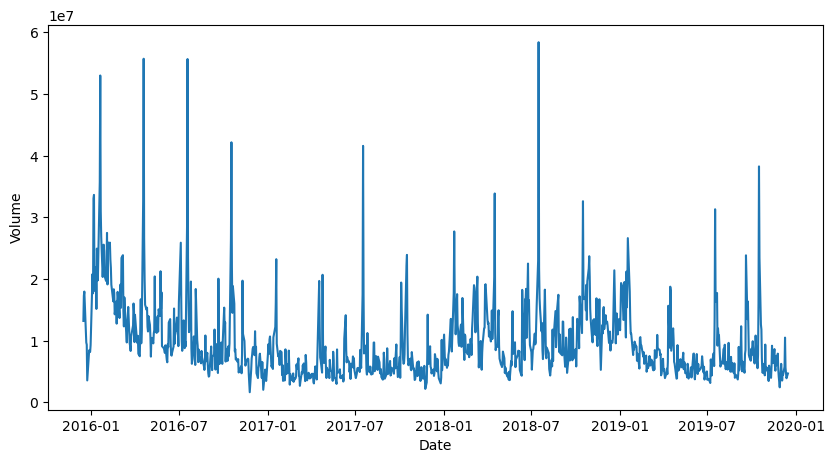

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(data_2.Volume)

Як ми можемо побачити майже усі дані повторюють одне одного

<AxesSubplot: >

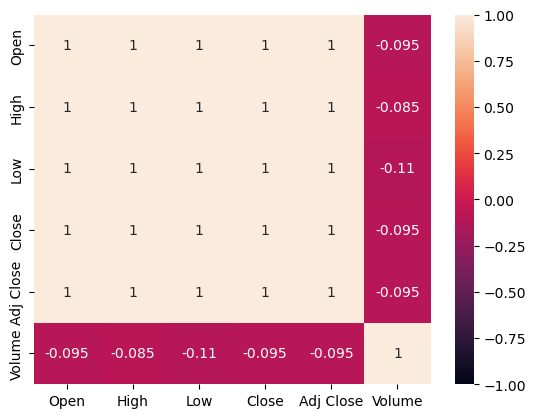

In [24]:
corr = data_2.corr()

sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

Дивлячись на матрицю кореляцій, та на графіки я вважаю, що нам потрібно взяти лише одну зміну, та створювати для неї криву, не використовуючи інші змінні і навіть об'єм, тому що як видно з матриці кореляцій і графіку він не надасть нам ніяких додаткових даних та інформації

Як зміну я обрав - Open 

In [25]:
X_data = np.array(data_2.reset_index().index)

y_data = data_2.Open.values

Нормалізація даних, створення поліномів, цього разу я обрав як степінь - 3, та розподіл на навчальний, валідаційний та тестовий датасети

In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=17)

poly = PolynomialFeatures(degree=DEGREE_2)

X_train = poly.fit_transform(X_train.reshape(-1, 1))
X_train_val = poly.transform(X_train_val.reshape(-1, 1))
X_test = poly.transform(X_test.reshape(-1, 1))
X_val = poly.transform(X_val.reshape(-1, 1))
X = poly.transform(X_data.reshape(-1, 1))

y_stdscaler = StandardScaler()

y_train = y_stdscaler.fit_transform(y_train.reshape(-1, 1))
y_train_val = y_stdscaler.transform(y_train_val.reshape(-1, 1))
y_test = y_stdscaler.transform(y_test.reshape(-1, 1))
y_val = y_stdscaler.transform(y_val.reshape(-1, 1))
y = y_stdscaler.transform(y_data.reshape(-1, 1))

x_stdscaler = StandardScaler()

X_train = x_stdscaler.fit_transform(X_train)
X_train_val = x_stdscaler.transform(X_train_val)
X_test = x_stdscaler.transform(X_test)
X_val = x_stdscaler.transform(X_val)
X = x_stdscaler.transform(X)

In [27]:
X_tf = tf.constant(X, dtype=tf.float32)
y_tf = tf.constant(y, dtype=tf.float32)

X_tf_train = tf.constant(X_train, dtype=tf.float32)
X_tf_train_val = tf.constant(X_train_val, dtype=tf.float32)
X_tf_test = tf.constant(X_test, dtype=tf.float32)
X_tf_val = tf.constant(X_val, dtype=tf.float32)

y_tf_train = tf.constant(y_train, dtype=tf.float32)
y_tf_train_val = tf.constant(y_train_val, dtype=tf.float32)
y_tf_test = tf.constant(y_test, dtype=tf.float32)
y_tf_val = tf.constant(y_val, dtype=tf.float32)

Створимо нову функція для підбору гіперпараметрів

In [28]:
def objective(trial):
    
    c_lambda_1 = trial.suggest_float("lambda_1", 1e-5, 1, log=True)
    c_lambda_2 = trial.suggest_float("lambda_2", 1e-5, 1, log=True)
    lrng_rate = trial.suggest_float("lrng_rate", 1e-5, 1, log=True)
    batch_size = trial.suggest_int("batch_size", 2, 32, 2)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(DEGREE_2 + 1,), kernel_regularizer=tf.keras.regularizers.l2(c_lambda_1)),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(c_lambda_2)),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lrng_rate),
            loss='mean_squared_error',
            metrics = [tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

    model.fit(X_tf_train, y_tf_train,
                    epochs=NUM_EPOCHS,
                    verbose=0, batch_size=batch_size,
                    validation_data=(X_tf_val, y_tf_val))

    score = model.evaluate(X_tf_val, y_tf_val, verbose=0)
    return score[0]

In [29]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=15, timeout=600, n_jobs=-1)

[I 2023-05-23 15:09:23,597] A new study created in memory with name: no-name-6caea0e9-7bc3-4b74-9619-e75bc94cde8c
[I 2023-05-23 15:09:51,490] Trial 0 finished with value: 0.05629952251911163 and parameters: {'lambda_1': 0.00036838521317512815, 'lambda_2': 5.1935483838939654e-05, 'lrng_rate': 0.19524982456521653, 'batch_size': 24}. Best is trial 0 with value: 0.05629952251911163.
[I 2023-05-23 15:09:51,843] Trial 3 finished with value: 0.06512236595153809 and parameters: {'lambda_1': 0.00032653167170638953, 'lambda_2': 2.870010329874652e-05, 'lrng_rate': 0.007395417654276322, 'batch_size': 24}. Best is trial 0 with value: 0.05629952251911163.
[I 2023-05-23 15:09:54,923] Trial 4 finished with value: 0.13483105599880219 and parameters: {'lambda_1': 0.010569588756789402, 'lambda_2': 1.8771310363687018e-05, 'lrng_rate': 0.1141925198351467, 'batch_size': 22}. Best is trial 0 with value: 0.05629952251911163.
[I 2023-05-23 15:09:57,943] Trial 2 finished with value: 1.9385794401168823 and param

In [30]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 15
Best trial:
  Value: 0.05629952251911163
  Params: 
    lambda_1: 0.00036838521317512815
    lambda_2: 5.1935483838939654e-05
    lrng_rate: 0.19524982456521653
    batch_size: 24


Тепер навчимо модель на навчальних та валідаційних данних

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(DEGREE_2 + 1,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00005)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.2),
              loss='mean_squared_error',
              metrics=[tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_tf_train_val, y_tf_train_val,
                    epochs=NUM_EPOCHS,
                    callbacks=[PrintLossCallback(),
                               tf.keras.callbacks.ModelCheckpoint(filepath="model_numpy_isprr2_2",
                                                                  save_best_only=True, verbose=0,
                                                                  save_weights_only=True)],
                    verbose=0, batch_size=24,
                    validation_data=(X_tf_test, y_tf_test))

y_pred_test = model.predict(X_tf_test)
y_pred_full = model.predict(X_tf)

Epoch 0: Loss = 0.1726, R_square = 0.8348, MSE = 0.1646,                   
 Val Loss = 0.08631634712219238, Val R Square = 0.9207894206047058, Val MSE = 0.07843956351280212 

Epoch 10: Loss = 0.0677, R_square = 0.9387, MSE = 0.0610,                   
 Val Loss = 0.09062101691961288, Val R Square = 0.9151599407196045, Val MSE = 0.08401422947645187 

Epoch 20: Loss = 0.0619, R_square = 0.9436, MSE = 0.0562,                   
 Val Loss = 0.08084004372358322, Val R Square = 0.9240100979804993, Val MSE = 0.07525020837783813 

Epoch 30: Loss = 0.0677, R_square = 0.9371, MSE = 0.0627,                   
 Val Loss = 0.060052674263715744, Val R Square = 0.9443649053573608, Val MSE = 0.055093538016080856 

Epoch 40: Loss = 0.0552, R_square = 0.9495, MSE = 0.0503,                   
 Val Loss = 0.05897894874215126, Val R Square = 0.9453305602073669, Val MSE = 0.05413730442523956 

Epoch 50: Loss = 0.0495, R_square = 0.9555, MSE = 0.0444,                   
 Val Loss = 0.03863390535116196, Val 

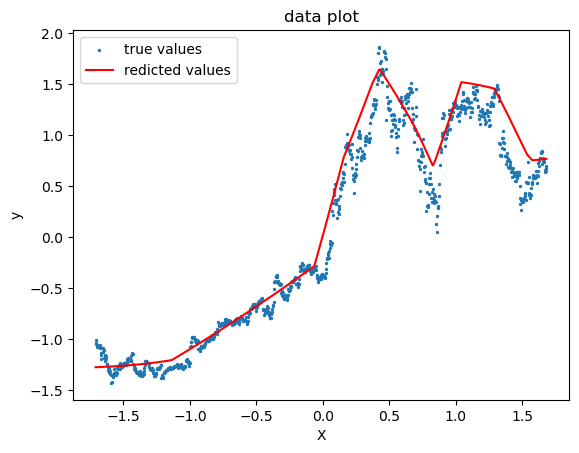

In [38]:
plt.scatter(x=X[:, 1], y=y, s=2, label='true values')
plt.plot(X[:, 1], y_pred_full, label='redicted values', c='red')
plt.title('data plot')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')

Як ми можемо побачити наша модель дуже гарно відтворює графік та має низьке значення MSE, та R^2 близьке до одиниці (~0.95)

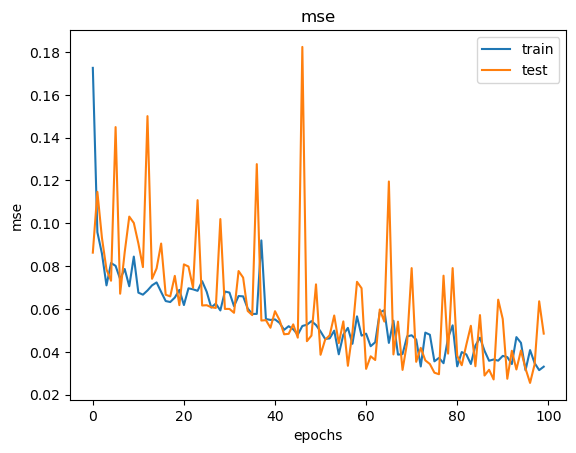

In [39]:
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="test")
plt.xlabel("epochs")
plt.ylabel("mse")
plt.title('mse')
plt.legend()
plt.show()

Саме навчання йшло гладко, це можна помітити з функції втрат для тренувального датасету, якщо враховувати діапазон значень, але для тренувального ми можемо помітити велику кількість різких збільшень, це може бути пов'язане з тим, що у тренувальний датасет потрапили викиди, подивимося на графік тренувальних значень, щоб перевірити, чи справді це так

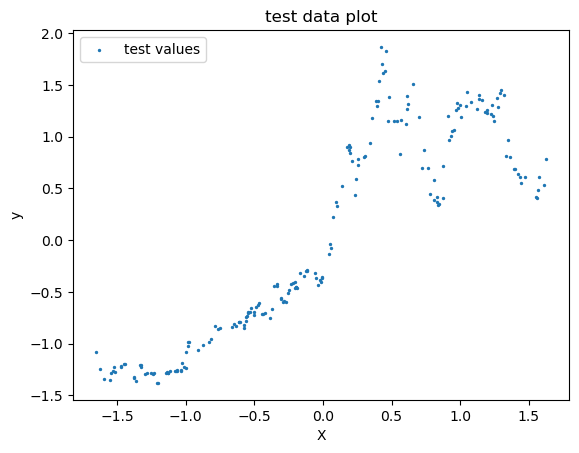

In [43]:
plt.scatter(x=X_test[:, 1], y=y_test, s=2, label='test values')
plt.title('test data plot')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')

Буде неправильним сказати, що ми тут маємо велику кількість викидів, але вони точно є, на жаль не можна повернутися назад та подивитися на графік який було створено у той момент (тому що ми зберігали лише найкращу модель), тому я не можу дати відповідь на те чому відбувалися такі різкі зміни для тренувальної функції втрат, але загалом вона повторювала шлях функції втрат для навчального датасету

# Висновок

У даній лабораторній роботі я навчився навчати регресiйної моделi методами градiєнтного спуску в TensorFlow, обидві моделі гарно пристосувалися для даних, та наскільки це можливо для поліноміальної лініної регресії пояснюють наші дані